In [28]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%matplotlib inline
%load_ext autoreload
% autoreload 2

In [3]:
import sys
import os
import inspect

SCRIPT_DIR = os.path.realpath(os.path.dirname(inspect.getfile(inspect.currentframe())))
CMAP2D_PATH = os.path.normpath(os.path.join(SCRIPT_DIR, 'src/cmap2d'))
if sys.path.count(CMAP2D_PATH) == 0:
    sys.path.append(CMAP2D_PATH)

PARENT_PATH = os.path.normpath(os.path.join(SCRIPT_DIR, '..'))
if sys.path.count(PARENT_PATH) == 0:
    sys.path.append(PARENT_PATH)
    
import cmap2d

In [4]:
import csv
import shapefile
import shapely.geometry as geom
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs
import matplotlib as mpl

import math
import numpy as np
from numpy import linalg as la
import statistics as stat
import itertools

In [49]:
def plot_pa_data(colors, ax=None, title=None, cmap=None, norm=None, hatch=None, show=True, orientation='vertical'):
    if cmap is not None:
        fig = plt.figure()#figsize=(8, 3))
        if orientation == 'horizontal':
            ax = fig.add_axes([0.05, 0.1, 0.9, 0.85], projection=ccrs.PlateCarree())
            ax2 = fig.add_axes([0.1, 0.05, 0.8, 0.05])
        else:
            ax = fig.add_axes([0.05, 0.05, 0.85, 0.9], projection=ccrs.PlateCarree())
            ax2 = fig.add_axes([0.925, 0.15, 0.05, 0.7])
    elif ax is None:
        ax = plt.axes(projection=ccrs.PlateCarree())
        
    for county,v in COUNTY_SHAPES.items():
        color = colors[county]
        cf = cfeature.ShapelyFeature([v], ccrs.PlateCarree(), label=county)
        kwargs = {"facecolor":color, "label": county}
        if hatch is not None and county in hatch:
            kwargs["hatch"] = hatch[county]
        artist = ax.add_feature(cf, **kwargs)
        artist.set_label(county)

    ax.set_extent([-80.5198510000000027,-74.7215190000000007,39.7211469999999949,42.5160720000000012])
    ax.set_aspect(1)
    if cmap is not None:
        cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation=orientation)
    if title is not None:
        ax.set_title(title)
    if show:
        plt.show()

In [98]:
def diff(x):
    return [x1-x0 for x0,x1 in zip(x[0:-1], x[1:])]

def sign(x):
    return math.copysign(1,x)

def change(x, tol=0.01):
    # Consider setting tol based on independent votes?
    return map(lambda x: sign(x) if abs(x) > tol else 0, diff(x))

def get_limits(limits, size=0.8, steps=4):
    start, end = limits
    mid = start + (end-start)/2
    step = size/steps
    new_mid = round(mid/step)*step
    new_start = new_mid-size/2
    new_end = new_mid+size/2
    return [new_start, new_end]

In [7]:
STATE = "PA"
STATE_CODES = {
    "PA": '42'
}


sf = shapefile.Reader("PA/tl_2011_us_county/tl_2011_us_county")
COUNTY_SHAPES = {}
iter = sf.iterShapeRecords()
for i in iter:
    if i.record[0] == STATE_CODES[STATE]:
        s = geom.shape(i.shape)
        COUNTY_SHAPES[i.record[4].capitalize()]=s
#         print(i.record[4].capitalize(),s.area)
        
print(len(COUNTY_SHAPES.keys()))

67


In [47]:
DEM = "DEM"
REP = "REP"
OTH = "OTH"

CANDIDATES = {
    2000: {DEM: 'Al Gore', REP: 'George Bush'},
    2004: {DEM: 'John Kerry', REP: 'George Bush'},
    2008: {DEM: 'Barack Obama', REP: 'John Mccain'},
    2012: {DEM: 'Barack Obama', REP: 'Mitt Romney'},
    2016: {DEM: 'Clinton, Hillary', REP: 'Trump, Donald J'}
}

def load_results(year):
    res = {}
    with open("PA/"+str(year) + "_county.csv",'r') as f:
        reader = csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader:
            county = row["County"]
            del row["County"]

            res[county] = row
    return res

def load_registrations(year):
    res = {}
    with open("PA/" + str(year) + "_registerd_voters_county.csv",'r') as f:
        reader = csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader:
            res[row["County"].capitalize()] = row
    return res

def load_data(year):
    return (load_registrations(year), load_results(year), 
            CANDIDATES[year][REP], CANDIDATES[year][DEM])

def get_votes(results, rc, dc):
    all_votes = sum(results.values())
    dems = results[dc]/all_votes
    reps = results[rc]/all_votes
    return reps, dems, all_votes

# a = np.array([[0.5,0.5,1],[1.0,0,1],[1,1,1]])
# b = np.array([[0,0,1],[-1,0,1],[0,-1,1]])
# l = la.solve(a,b)
def xvert(dem, rep):
#     h_coord = np.array((x,y,1))
#     return np.dot(h_coord,l)[:2].tolist()
    return [rep-dem, 1-dem-rep]

def _get_year_results(year):
    if year>2000:
        xvot,xres,xrc,xdc = load_data(year-4)
    yvot,yres,yrc,ydc = load_data(year)
    counties = yvot.keys()
    
    ret = {}
    for county in counties:
        new_rep, new_dem, new_all = get_votes(yres[county], yrc, ydc)
        winner = OTH
        if new_rep > new_dem:
            winner = REP
        elif new_dem >  new_rep:
            winner = DEM
        value = xvert(new_dem,new_rep)
        flipped = False
        # TODO: This could be smarter (try...catch?)
        if year>2000:
            old_rep, old_dem, old_all = get_votes(xres[county], xrc, xdc)
            flipped = (winner == DEM and old_rep>old_dem) or (winner == REP and old_dem>old_rep)
        ret[county] = {REP: new_rep, DEM: new_dem, 'total':new_all, 'vap':yvot[county]["ALL"],
                       'flipped':flipped, 'winner': winner, 'value': value}
    return ret

def get_year_results(years):
    if type(years) == int:
        return _get_year_results(years)
    
    results = {}
    for year in years:
        res = get_year_results(year)
        counties = res.keys()
        for county in counties:
            r = res[county]
            results.setdefault(county, {k:[] for k in r.keys()})
            for k,v in r.items():
                results[county][k].append(v)
    return results

years = sorted(CANDIDATES.keys())
results = get_year_results(years)

In [11]:
def print_summary(year):
    res = get_year_results(year)
    total = sum([r['total'] for r in res.values()])
    dem_votes = sum([r[DEM]*r['total'] for r in res.values()])
    rep_votes = sum([r[REP]*r['total'] for r in res.values()])
    vap = sum([r['vap'] for r in res.values()])
    winner = CANDIDATES[year][DEM] if dem_votes > rep_votes else CANDIDATES[year][REP]
    
    print(winner+" won the election by " + str(round(abs(dem_votes-rep_votes)/total*100, 2)) + "%")
    print("there was a total of " + str(int(total)) + " votes cast.")
    print(str(round((total-dem_votes-rep_votes)/total*100,2))+"% of votes were not dem or rep.")
    print("voter turnout for state was " + str(round(total/vap*100,2)) + "% (" + str(int(total)) + " of " +str(int(vap)) + ")")

## Notes and Terminology

The metric I will use in this post is the *differential* metric, which is computed as the difference of two values. Most commonly, I compute the ***Vote Differential***, abbreviated **VD**, as the difference in votes for Republican and Democratic candidates, as a percentage of total votes. I also compute the ***Registration Differential*** (**RD**), which is difference in registered Republicans and Democrats, as a percentage of total registered voters. 

I also commonly refer to the ***Independent Vote*** (**IV** for short), by which I mean to refer to all votes cast for neither of the 2 primary parties, as a percentage of total registered voters.

Whenever I talk about voter turnout or other similar values, I use ***Registered Voters*** (**RV** for short) as a substitute for eligible voters (also called *voting age population*). This has many obvious flaws (most important being that not all eligible voters register, and the difference between registration and eligible population is likely not uniformly distributed across states), but computing a more accurate value is far more complex and may not even be possible, due to relying on data that isn't readily available at a county level for each state. 

1. Explain Terminology and methods
2. Pull out interesting analysis
2. Generalize to other states

## State Results - First Look


In [12]:
YEAR=2004
print_summary(YEAR)

John Kerry won the election by 2.49%
there was a total of 5747431 votes cast.
0.7% of votes were not dem or rep.
voter turnout for state was 68.69% (5747431 of 8366663)


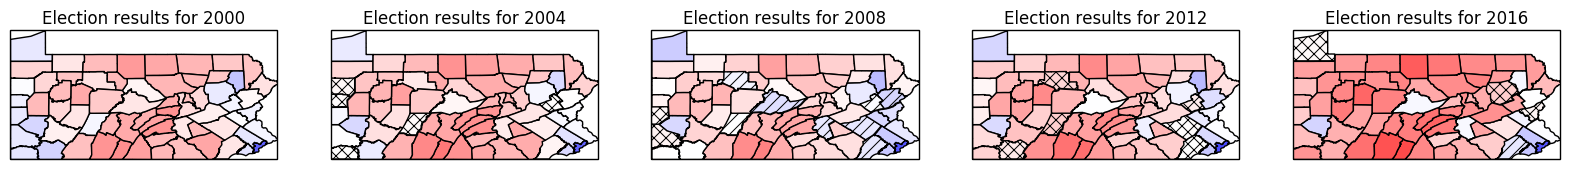

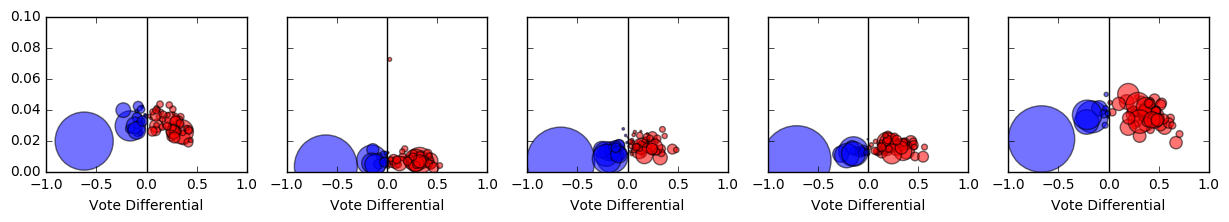

In [62]:
def _plot_year_results_on_map(ax, year):
    results = get_year_results(year)
    counties = results.keys()

    colormap = cm.get_cmap("bwr")
    norm = clrs.Normalize(vmin=-1, vmax=1)
    sm = cm.ScalarMappable(norm=norm, cmap=colormap)

    colors = {c: sm.to_rgba(results[c]['value'][0]) for c in counties}
    flipped = {c: '//' if results[c]['winner'] == DEM else 'xx' for c in counties if results[c]['flipped']}

    plot_pa_data(colors, ax=ax, hatch=flipped, title="Election results for " + str(year),
                orientation='horizontal', show=False)
    
def _plot_year_results_as_graph(ax, year):
    results = get_year_results(year)
    counties = results.keys()
    ax.scatter([results[c]['value'][0] for c in counties], [results[c]['value'][1] for c in counties], 
                c=[[1,0,0] if results[c]['winner'] == REP else [0,0,1] for c in counties],
                s=[abs(results[c]['value'][0])*results[c]['total']/200 for c in counties],
                alpha=0.55)
    ax.set_ylim([0,0.1])
    ax.plot([0,0],[0,0.8], 'k')
    ax.set_xlim([-1,1])
    ax.set_xlabel("Vote Differential")
#     ax.set_ylabel("Independent Vote")

def plot_year_results(years):
    n_years = len(years)
    fig, axes = plt.subplots(1, n_years, figsize=(n_years*4, 2), subplot_kw={'projection': ccrs.PlateCarree()})
    for i, year in enumerate(years):
        _plot_year_results_on_map(axes[i], year)

    fig, axes = plt.subplots(1, n_years, sharey=True, figsize=(n_years*3, 2))
    for i, year in enumerate(years):
        _plot_year_results_as_graph(axes[i], year)

    plt.show()
plot_year_results(years)

The above figure plots every county in 2D space, where the x coordinate is the Vote Differential in that county, and the y coordinate is the Independent Vote in that county. The size of each point is the number of marginal votes that county yielded for the winning party in that county.

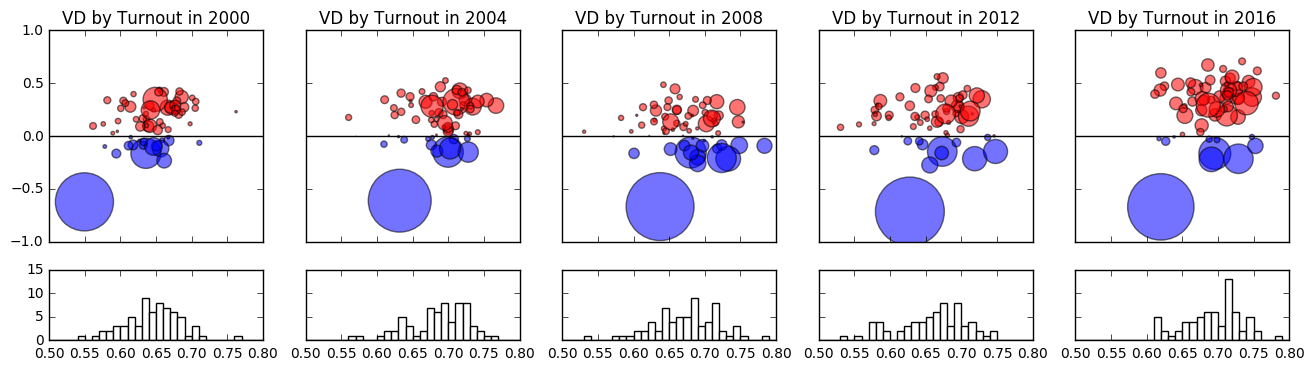

In [48]:
def _plot_turnout_vs_results(ax1, ax2, year):
    # correlation between voter turnout and results
    res = get_year_results(year)
    counties = sorted(res.keys())
    turnout = [res[c]['total']/res[c]['vap'] for c in counties]
    values = [res[c]['value'][0] for c in counties]
    colors = [[1,0,0] if res[c]['winner'] == REP else [0,0,1] for c in counties]
    ax1.scatter(turnout, values, c=colors, 
                s=[abs(res[c]['value'][0])*res[c]['total']/200 for c in counties], alpha=0.55)
#     ax1.scatter(turnout, values, marker='x', c=colors)
    ax1.plot([-1,1], [0,0], 'k')

    ax1.set_xlim([0.5, 0.8])
    ax1.set_ylim([-1.0,1.0])
    ax1.set_title("VD by Turnout in " + str(year))

    # distribution of voter turnout
    n, bins, patches = ax2.hist(turnout, bins=np.linspace(0,1.0, 101), facecolor='white', alpha=1)
#     start, end = ax2.get_ylim()
    end = 15
    ax2.yaxis.set_ticks(np.linspace(0, math.ceil(end/5)*5, 4))
    ax2.set_ylim([0, math.ceil(end/5)*5])


def plot_turnout_vs_results(years):
    fig, axes = plt.subplots(2, len(years), sharex=True, sharey='row', figsize=(16, 4),
                                   gridspec_kw = {'height_ratios':[3, 1]})
    for i, year in enumerate(years):
        _plot_turnout_vs_results(axes[0][i], axes[1][i], year)
    plt.show()

plot_turnout_vs_results(years)

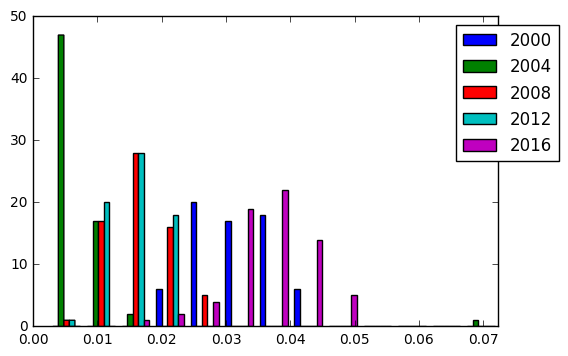

In [409]:
# How did the independent vote change for each year?
oth_deltas = []
for county, res in results.items():
#     res = results[county]
    y = [v[1] for v in res['value']]
    oth_deltas.append(y)
o = np.array(oth_deltas)
# for some reason we need to use np to calculate the proper bins...
_,bins = np.histogram(o, bins='auto', density=False)
res, _, p = plt.hist(o, bins=bins, label=years)
plt.legend(loc='upper center', bbox_to_anchor=(1.02,1.0))
plt.xlim([0,max(bins)])
plt.show()

## Historical Trends

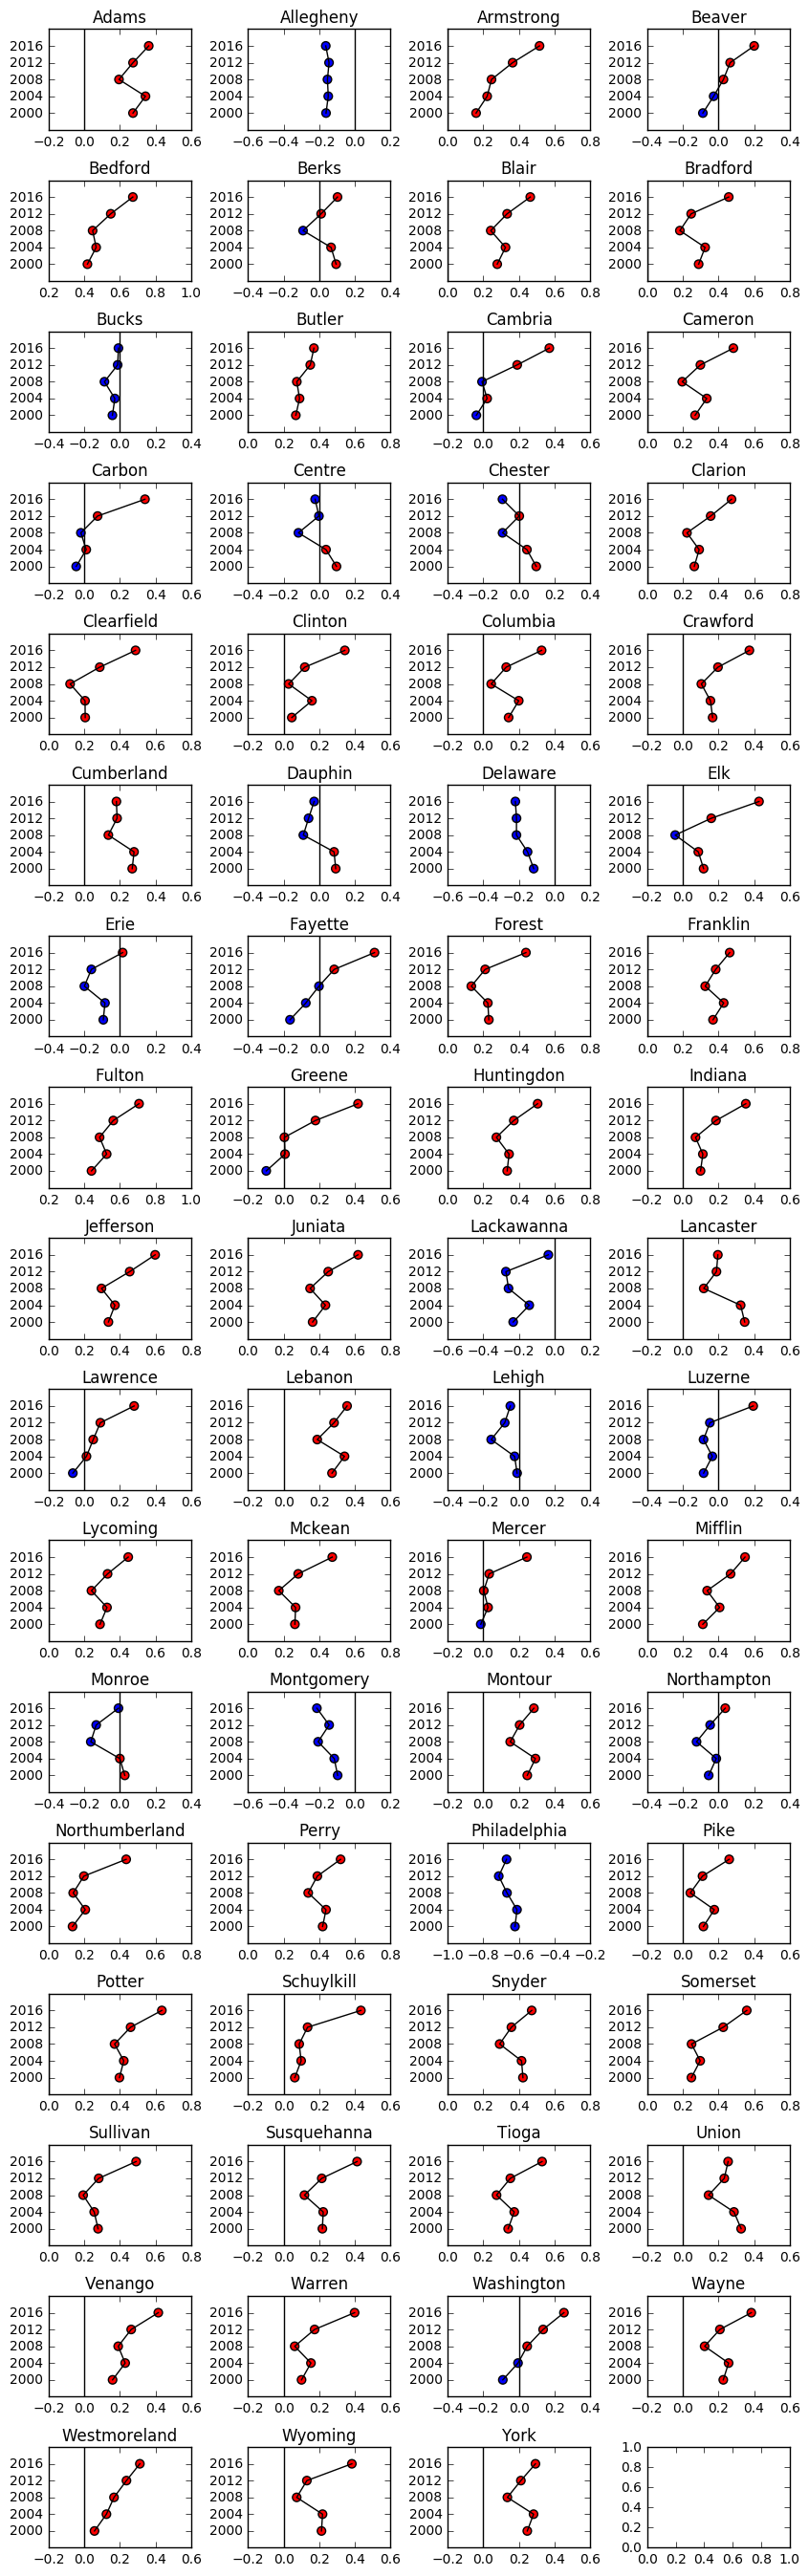

In [97]:
# plot results by year as a trace for each county
results = get_year_results(years)
def trace(points, ax=None):
    if ax is None:
        ax=plt.gca()
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    ax.plot(x,y,'k')
    colors = [[1,1,1]] + [[0,1,0]]*(len(x)-2) + [[0,0,0]]
    ax.scatter(x,y,c=colors)

colormap = cm.get_cmap("bwr")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')
norm = clrs.Normalize(vmin=-1, vmax=1)
sm = cm.ScalarMappable(norm=norm, cmap=colormap)

def trail(points, ax=None):
    if ax is None:
        ax=plt.gca()
    x = [p[0] for p in points]
    y = range(len(x))
    ax.plot(x,y,'k')
    ax.scatter(x,y, c=[[1,0,0] if v>0 else [0,0,1] for v in x], s=40)
    
ncols = 4
nrows = math.ceil(len(results.keys())/ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(2.5*ncols, nrows*2))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
size = []
for i, county in enumerate(sorted(results.keys())):
    res = results[county]
    ax = axes.flat[i]
    trail(res['value'], ax)

    ax.set_title(county)
#     ax.set_ylim([0, 0.1])

    ax.set_ylim([-1, 5])
    ax.yaxis.set_ticks([0,1,2,3,4])
    ax.yaxis.set_ticklabels(list(range(2000,2017,4)))
    
    start,end = get_limits(ax.get_xlim(), 0.8, 4)
    ax.xaxis.set_ticks(np.linspace(start, end, 5))
    ax.plot([0,0],[-2,6],'k')
    ax.set_xlim([start,end])

plt.show()

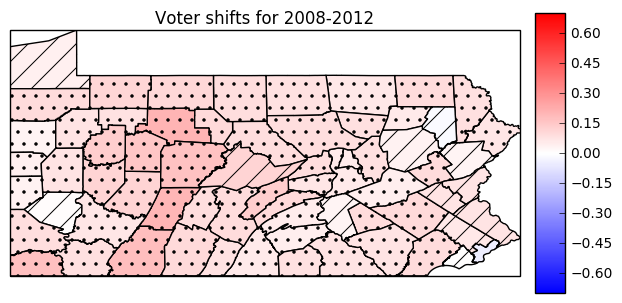

In [69]:
def plot_year_shifts(year):
    results = get_year_results([year-4, year])

    colormap = cm.get_cmap("bwr")
    colormap.set_bad('orange')
    colormap.set_over('g')
    colormap.set_under('k')
    norm = clrs.Normalize(vmin=-0.7, vmax=0.7)
    sm = cm.ScalarMappable(norm=norm, cmap=colormap)
    
    counties = sorted(results.keys())
    

    colors = {c: sm.to_rgba(diff([x[0] for x in v['value']])[0]) for c,v in results.items()}
    winner = {}
    for county in counties:
        win = results[county]['winner'][-1]
        if win == DEM:
            winner[county] = "/"
        elif win == REP:
            winner[county] = "."

    plot_pa_data(colors, title="Voter shifts for " + str(year-4) + "-" + str(year), hatch=winner,
                cmap=colormap, norm=norm)
    
plot_year_shifts(2012)

(67, 4)
0.761569432562


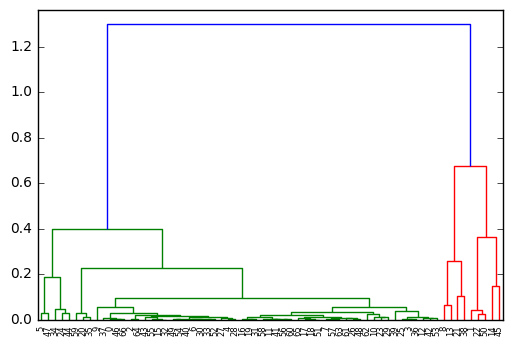

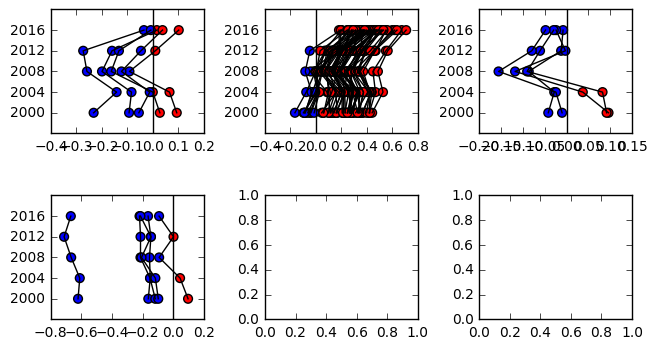

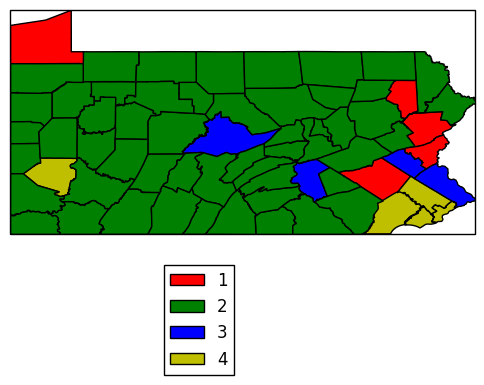

In [321]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import inconsistent
# from sklearn import metrics

counties = sorted(results.keys())
# a = np.array([list(change([x[0] for x in results[c]['value']], 0.03)) for c in counties])
# a = np.array([[x[0] for x in results[c]['value']] for c in counties])
X = np.array([list(diff([x[0]*i*10 for i,x in enumerate(results[c]['value'])])) for c in counties])
# b = np.array([[w==REP for w in results[c]['winner']] for c in counties])
# b = np.array([[results[c]['winner'][-1]==REP] for c in counties])
# X = np.concatenate((a.T,b.T),).T
print(np.shape(X))
Z = linkage(X, 'average', metric='cosine')
# Z = linkage(X, 'ward')

c, coph_dists = cophenet(Z, pdist(X))
print(c)
dendrogram(Z)
plt.show()

k = 4
clusters = fcluster(Z, k, criterion='maxclust')

# print(metrics.calinski_harabaz_score(X, clusters))

ncols = 3
nrows = math.ceil(k/ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(2.5*ncols, nrows*2))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(1,k+1):
    ax =  axes.flat[i-1]
    for points in np.array([results[c]['value'] for c in counties])[clusters==i]:
        trail(points,ax)
    ax.set_ylim([-1, 5])
    ax.yaxis.set_ticks([0,1,2,3,4])
    ax.yaxis.set_ticklabels(list(range(2000,2017,4)))
    
#     start,end = get_xlim(ax.get_xlim())
#     ax.xaxis.set_ticks(np.linspace(start, end, 5))
    ax.plot([0,0],[-2,6],'k')
#     ax.set_xlim([start,end])

plt.show()

color_cycle = ['r', 'g', 'b', 'y', 'purple', 'white', 'k']
colors = {c:color_cycle[clusters[i]-1] for i,c in enumerate(counties)}
plot_pa_data(colors, show=False)

legend_texts = list([str(i) for i in range(1,k+1)])
legend_artists = [mpl.patches.Patch(facecolor=color_cycle[i-1], edgecolor='k') for i in range(1,k+1)]
plt.legend(legend_artists, legend_texts, bbox_to_anchor=(0.5,-0.1))
plt.show()

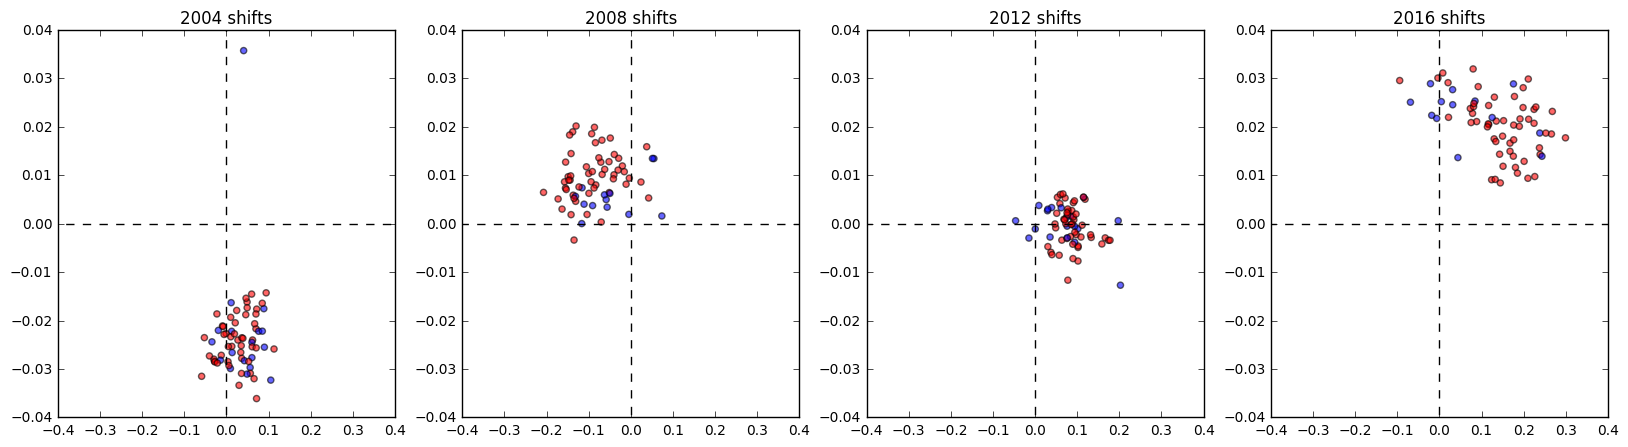

In [106]:
# Check out shifts in dems vs rep votes
def _plot_party_vote_shifts(ax, new_year, old_year):
    results = get_year_results([old_year, new_year])
    counties = sorted(results.keys())
    x = [diff([x[0] for x in results[c]['value']])[0] for c in counties]
    y = [diff([x[1] for x in results[c]['value']])[0] for c in counties]
    
    b = 0.15

    colors = [[1,0,0] if results[c]['winner'][0] == REP else [0,0,1] for c in counties]
    ax.scatter(x, y, alpha=0.6, c=colors)
#     xl, xu = get_limits(ax.get_xlim(), 0.5, 5)
#     yl, yu = get_limits(ax.get_ylim(), 0.1, 4)
    ax.plot([-1,1],[0,0], 'k--')
    ax.plot([0,0], [-1,1], 'k--')
#     ax.set_xlim([xl, xu])
#     ax.set_ylim([yl, yu])
#     ax.plot([-b,b], [0,0], 'k')
#     ax.plot([0,0], [-b,b], 'k')
#     ax.plot([-b,b], [b,-b], 'k--')
#     ax.set_xlim([-b,b])
#     ax.set_ylim([-b,b])
    ax.set_xlim([-.4, .4])
    ax.set_ylim([-.04, .04])
    ax.set_title("%i shifts"% (new_year))
    

def plot_party_vote_shifts(years):
    fig, axes = plt.subplots(1, len(years)-1, squeeze=False, figsize=((len(years)-1)*5, 5))
    for i in range(len(years)-1):
        _plot_party_vote_shifts(axes[0][i], years[i+1],years[i])
    plt.show()

    
plot_party_vote_shifts(years)
plt.show()


## Registration vs Votes

In [ ]:
def _format_result_values(value):
    if type(value) == float:
        if value < 1:
            return '{0:.3f}'.format(value)
        else:
            return '{0:.0f}'.format(value)
    elif type(value) == list:
        return [_format_result_values(v) for v in value]
    else:
        return str(value)

def print_county_table(year):
    results = get_year_results(year)
    counties = sorted(list(results.keys()))
    longest = max(map(len, counties))
    columns = results[counties[0]].keys()
    print(('{0:'+str(longest)+'s}').format('county'),*columns)
    for county in counties:
        values = map(_format_result_values, results[county].values())
        print(('{0:'+str(longest)+'s}').format(county), *values)
        
print_county_table(YEAR)

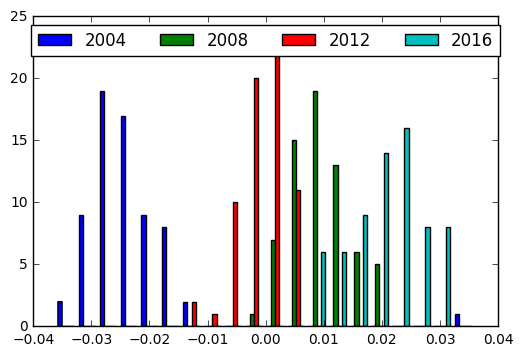

In [15]:
# How did the independent vote change for each year?
oth_deltas = []
for i, county in enumerate(sorted(results.keys())):
    res = results[county]
    y = [v[1] for v in res['value']]
    d = list(diff(y))
    oth_deltas.append(d)
o = np.array(oth_deltas)
# np.histogram(o[:,1], bins='auto', density=False)
plt.hist(o, bins='auto', label=[2004, 2008, 2012, 2016])
plt.legend(ncol=4, loc='upper center')
plt.show()

Bucks REPS lost after gaining in past! [1.0, -1.0, 1.0, 0]
Dauphin REPS lost after gaining in past! [0, -1.0, 1.0, 1.0]
Lackawanna REPS lost after gaining in past! [1.0, -1.0, -1.0, 1.0]
Lackawanna is -1-11 [1.0, -1.0, -1.0, 1.0]
Lehigh REPS lost after gaining in past! [-1.0, -1.0, 1.0, 1.0]
Monroe REPS lost after gaining in past! [-1.0, -1.0, 1.0, 1.0]
Philadelphia REPS lost after gaining in past! [1.0, -1.0, -1.0, 1.0]
Philadelphia is -1-11 [1.0, -1.0, -1.0, 1.0]


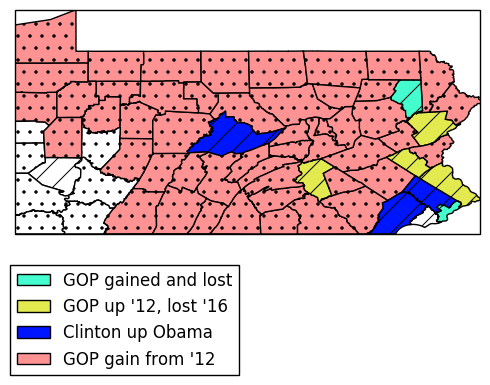

In [70]:
colors = {}
winner = {}
for i, county in enumerate(sorted(results.keys())):
    res = results[county]
    win = res['winner'][-1]
    if win == DEM:
        winner[county] = "/"
    elif win == REP:
        winner[county] = "."
# any counties where side was either [xx1] or [x10] and still lost?
    x = [v[0] for v in res['value']]
    d = list(change(x))
    d2,d1,d0 = d[-3:]
    if (d0 == 1 or d0 == 0 and d1 == 1) and win == DEM:
        print("%s REPS lost after gaining in past!" % county, d)
    if (d0 == -1 or d0 == 0 and d1 == -1) and win == REP:
        print("%s DEMS lost after gaining in past!" % county, d)
# classify:
#  x1-1 : C1 (total surprise?)
#  -1x1 : C2 (shoulda known?)
#  -11x : C4 (huh)
    cls = 0
    if (d1==1 and d0==-1) or (d1==-1 and d0==1):
        cls += 1
    if (d2==-1 and d0==1) or (d2==1 and d0==-1):
        cls += 2
    if (d2==-1 and d1==1) or (d2==1 and d1==-1):
        cls += 4
    color = black = [0,0,0]
    # -11x : GOP gain '12
    if (cls == 4 or cls == 6) and d2==-1:
        # ... and won in '16
        if win == REP:
            color = [1.0, 0.576, 0.576]
        # ... and lost in '16
        elif win == DEM:
            color = [0.886, 0.918, 0.31]
    # 000 : nothing interesting
    elif cls == 0:
        color = [1,1,1]
#         print('{0} is not interesting'.format(county), d)
    # -11-1: Dems gained ground that Obama '12 lost
    elif cls == 5 and d2==-1 and d0==-1:
        color = [0.0, 0.082, 1.0]
    # -1-11: Clinton lost ground she shouldn't have
    elif cls == 3 and d2==-1 and d1==-1:
        # ... but still won
        if win == DEM:
            print('{0} is -1-11'.format(county), d)
            color = [0.267, 0.988, 0.808]
        # ... and lost
        elif win == REP:
            color = [0.988, 0.267, 0.953]
    if color == black:
        print('{0} given class {1:0=3b} and winner {2}'.format(county, cls, win), d)
    colors[county] = color

plot_pa_data(colors, show=False, hatch=winner)
legend = {
    "GOP gain from '12": [1.0, 0.576, 0.576],
    "Clinton up Obama" : [0.0, 0.082, 1.0],
    "GOP gained and lost": [0.267, 0.988, 0.808],
    "GOP up '12, lost '16": [0.886, 0.918, 0.31]
}

legend_texts = list(legend.keys())
legend_artists = [mpl.patches.Patch(facecolor=legend[t], edgecolor='k') for t in legend_texts]
plt.legend(legend_artists, legend_texts, bbox_to_anchor=(0.5,-0.1))
plt.show()

(0, 1)

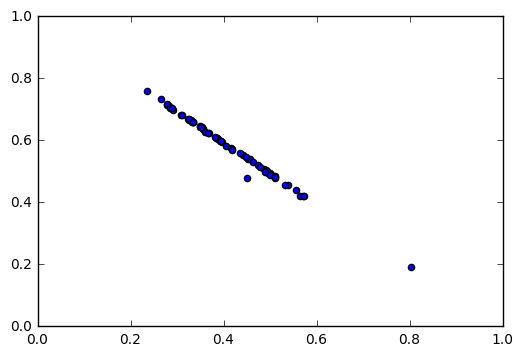

In [71]:
results = get_year_results(2004)
reps = [r[REP] for r in results.values()]
dems = [r[DEM] for r in results.values()]


plt.scatter(dems, reps)
plt.xlim([0,1])
plt.ylim([0,1])

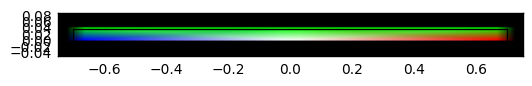

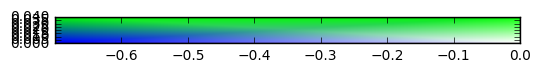

In [160]:
def make_cmap(xmin, xmax, ymin, ymax, ll, lr, ur, ul):
    return cmap2d.ColorMapCrude([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]],
                           [ll, lr, ur, ul])
s=0.7
o=0.04
cmap = make_cmap(-s, s, 0, o, (0,1,0), (0,0,1), (1,1,1), (1,0,0))

d_cmap = make_cmap(-s, 0, 0, o, (0,0,1), (1,1,1), (0,1,0), (0,1,0))
r_cmap = make_cmap(0, s, 0, o, (1,1,1), (1,0,0), (0,1,0), (0,1,0))

def color_code(point):
    x,y = point
    if x>0:
        return r_cmap(point)
    else:
        return d_cmap(point)

color_code._coords = cmap._coords

# colors = {county:color_code((d_delta[county], r_delta[county])) for county in counties}

cmap2d.plot_cmap(color_code, scale=4, buffer=0.05, show=False)
# cmap2d.plot_color_points([v for v in zip(x,y)], [colors[c] for c in counties])
plt.show()
# cmap = cmap2d.TernaryColorMap([[-0.7,0],[0.7,0],[0.7,0.04], [-0.7, 0.04]],[(0,0,1),(1,0,0),(1,1,0),(0,1,1)])
cmap2d.plot_cmap(d_cmap)

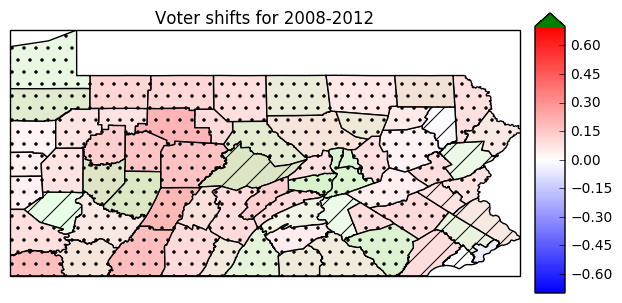

In [161]:
def plot_year_shifts(year):
    results = get_year_results([year-4, year])

    colormap = cm.get_cmap("bwr")
    colormap.set_bad('orange')
    colormap.set_over('g')
    colormap.set_under('k')
    norm = clrs.Normalize(vmin=-0.7, vmax=0.7)
    sm = cm.ScalarMappable(norm=norm, cmap=colormap)
    
    counties = sorted(results.keys())
    
    oth_norm = clrs.Normalize(vmin=0, vmax=0.04, clip=True)
   
    colors = {c: color_code([diff([x[0] for x in v['value']])[0],max(diff([x[1] for x in v['value']])[0],0)]) for c,v in results.items()}
    plot_pa_data(colors, title="Voter shifts for " + str(year-4) + "-" + str(year), hatch=winner,
                cmap=colormap, norm=norm)
    
plot_year_shifts(2012)

In [155]:
colormap = cm.get_cmap("bwr")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')
norm = clrs.Normalize(vmin=-0.7, vmax=0.7)
sm = cm.ScalarMappable(norm=norm, cmap=colormap)
print(sm.to_rgba(0.01))
print(sm.to_rgba(-0.01))

(1.0, 0.9882352941176471, 0.9882352941176471, 1.0)
(0.9882352941176471, 0.9882352941176471, 1.0, 1.0)


In [44]:
old_year=2012
new_year=2016

def get_shift_data(old_year, new_year):
    xvot,xres,xrc,xdc = load_data(old_year)
    yvot,yres,yrc,ydc = load_data(new_year)
    counties = xvot.keys()


    r_delta, d_delta, flipped = {},{},{}
    for county in counties:
        old_rep, old_dem, old_all = get_votes(xres[county], xrc, xdc)
        new_rep, new_dem, new_all = get_votes(yres[county], yrc, ydc)
        r_delta[county] = new_rep - old_rep
        d_delta[county] = new_dem - old_dem
        if (new_dem>new_rep and old_rep>old_dem):
            flipped[county] = '//'
        if (new_rep>new_dem and old_dem>old_rep):
            flipped[county] = 'xx'
            
    return r_delta, d_delta, flipped

r_delta, d_delta, flipped = get_shift_data(old_year, new_year)
#     print(min(r_delta.values()), max(r_delta.values()))
#     print(min(d_delta.values()), max(d_delta.values()))
b = 0.3

x = [d_delta[county] for county in counties]
y = [r_delta[county] for county in counties]


In [45]:
def project(a, b):
    """Project vector b onto line given by vector a"""
    a_ = np.array(a)
    b_ = np.array(b)
    return np.dot(a_.T,b_)/np.dot(a_.T,a_)*a_

def project_to_shift_line(r_delta, d_delta, normalized=True):
    max_dist = math.sqrt(2)*2*b
    p = np.array((-b, b))
    ret = {}
    error = 0
    for county, d_d in d_delta.items():
        r_d = r_delta[county]
        v = np.array((d_d, r_d))
        error += la.norm(project(p2,v)-v)
        distance = la.norm(v-p)
        if normalized:
            distance /= max_dist
        else:
            distance -= max_dist/2
        ret[county] = distance
    print(error/len(d_delta.keys()))
    return ret
    # This projects to the line first, then takes the distance.
    # Doesn't seem to make any difference...
    # colors = {county:colormap(la.norm(project(p2,(d_delta[county], r_delta[county]))-p2)/max_dist) for county in counties}

colormap = cm.get_cmap("bwr_r")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

colors = {c: colormap(v) for c,v in project_to_shift_line(r_delta, d_delta).items()}

plot_pa_data(colors, hatch=flipped, title="Gains from "+str(old_year)+" to " + str(new_year))

vv = list(project_to_shift_line(r_delta, d_delta).values())
ww = list(project_to_shift_line(r_delta, d_delta, normalized=False).values())
yy = [1 for v in vv]
plt.scatter(vv,yy)
yy = [2 for v in ww]
plt.scatter(ww,yy)
plt.show()

plt.scatter(x,y, c=[colors[c] for c in counties])
plt.gca().set_aspect(1)
plt.plot([-b,b], [0,0], 'k')
plt.plot([0,0], [-b,b], 'k')
plt.plot([-b,b], [b,-b], 'k')
plt.xlim([-b,b])
plt.ylim([-b,b])
plt.show()

NameError: name 'p2' is not defined

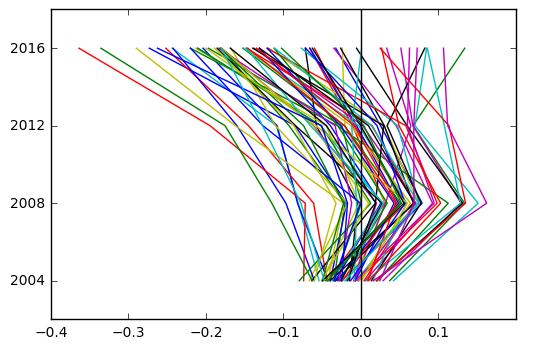

In [415]:
shifts = {}
years = list(range(2004,2017,4))
for year in years:
    r_delta, d_delta, flipped = get_shift_data(2000, year)
    shift = project_to_shift_line(r_delta, d_delta, normalized=False)
    for c,v in shift.items():
        shifts.setdefault(c, {"values":[], "flips":[]})
        shifts[c]["values"].append(v)
    for c,f in flipped.items():
        shifts[c]["flips"].append(f)
        
for county in shifts.keys():
    plt.plot(shifts[county]["values"], years)
plt.plot([0,0], [min(years)-2, max(years)+2], 'k')
plt.ylim([min(years)-2, max(years)+2])
plt.xlim([-.4,.2])
plt.yticks(years)
plt.show()
    

In [416]:
shifts["Erie"]

{'flips': ['xx'],
 'values': [-0.0061814616207136464,
  0.075306318729929655,
  0.047504181200756168,
  -0.076856523434683799]}

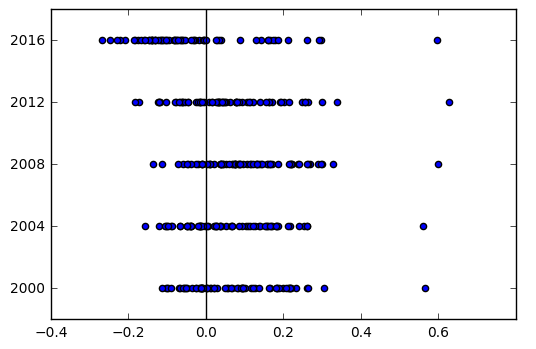

In [434]:
years = list(range(2000,2017,4))
for year in years:
    vot,res,rc,dc = load_data(year)
    
    max_dist = math.sqrt(2)*2*1
    p = np.array((-1, 1))
    values = {}
    for county, result in res.items():
        rep, dem, all_votes = get_votes(result, rc, dc)
        distance = la.norm(np.array((dem, rep))-p)
        distance -= max_dist/2
#         md = rep+dem
#         distance = dem/md - 0.5
        values[county] = distance
    plt.scatter(list(values.values()), [year]*len(res.keys()))
plt.plot([0,0], [min(years)-2, max(years)+2], 'k')
plt.ylim([min(years)-2, max(years)+2])
plt.yticks(years)
plt.xlim([-.4, 0.8])
plt.show()

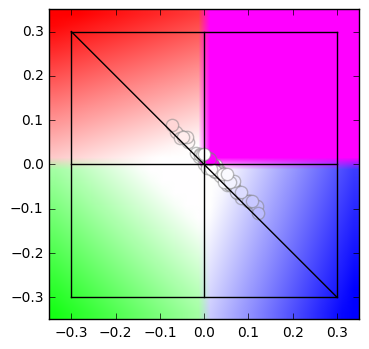

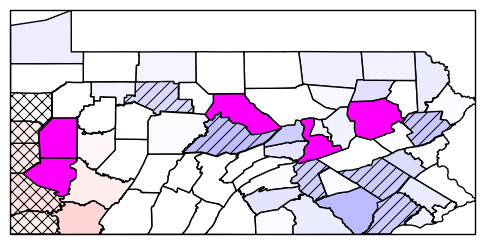

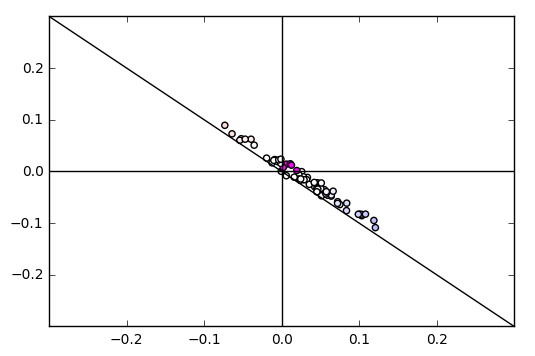

In [347]:
b = 0.3
x = [d_delta[county] for county in counties]
y = [r_delta[county] for county in counties]

def make_cmap(xmin, xmax, ymin, ymax, ll, lr, ur, ul):
    return cmap2d.ProjectionColorMap([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]],
                           [ll, lr, ur, ul])

cmap = make_cmap(-b, b, -b, b, (0,1,0), (0,0,1), (1,1,1), (1,0,0))
# r_cmap = make_cmap(-b, 0, 0, b, (1,1,0), (1,1,1), (1,0.5,0.5), (1,0,0))
# d_cmap = make_cmap(0, b, -b, 0, (0,1,1), (0,0,1), (0.5,0.5,1), (1,1,1))
# o_cmap = make_cmap(-b, 0, -b, 0, (0,1,0), (0,1,1), (1,1,1), (1,1,0))

r_cmap = make_cmap(-b, 0, 0, b, (1,1,1), (1,1,1), (1,0.5,0.5), (1,0,0))
d_cmap = make_cmap(0, b, -b, 0, (1,1,1), (0,0,1), (0.5,0.5,1), (1,1,1))
o_cmap = make_cmap(-b, 0, -b, 0, (0,1,0), (1,1,1), (1,1,1), (1,1,1))


def color_code(point):
    x,y = point
    if x>0:
        if y>0:
            return (1,0,1)
        else:
            return d_cmap(point)
    else:
        if y>0:
            return r_cmap(point)
        else:
            return o_cmap(point)

color_code._coords = cmap._coords

x = [d_delta[county] for county in counties]
y = [r_delta[county] for county in counties]

colors = {county:cmap((d_delta[county], r_delta[county])) for county in counties}
colors = {county:color_code((d_delta[county], r_delta[county])) for county in counties}

plt.plot([-b,b], [0,0], 'k')
plt.plot([0,0], [-b,b], 'k')
plt.plot([-b,b], [b,-b], 'k')
cmap2d.plot_cmap(color_code, scale=4, buffer=0.05, show=False)
cmap2d.plot_color_points([v for v in zip(x,y)], [colors[c] for c in counties])
plt.show()

plot_pa_data(colors, hatch=flipped)

plt.scatter(x,y, c=[colors[c] for c in counties])
plt.plot([-b,b], [0,0], 'k')
plt.plot([0,0], [-b,b], 'k')
plt.plot([-b,b], [b,-b], 'k')
plt.xlim([-b,b])
plt.ylim([-b,b])
plt.show()

28281236.1447 27698.6789508


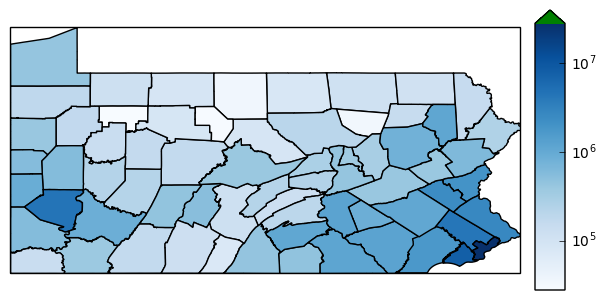

In [42]:
# Plot voter density by county

# ax = plt.axes(projection=ccrs.PlateCarree())
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

norm = colors.LogNorm()

to_plot = []
for county,v in COUNTY_SHAPES.items():
    vap = int(dict(VOTERS[county])["ALL"])
    value = vap/v.area
    to_plot.append((county, v, value))

norm.autoscale_None([k[2] for k in to_plot])
print(norm.vmax, norm.vmin)

sm = cm.ScalarMappable(norm=norm, cmap=colormap)

values = {}
for (county, shape, value) in to_plot:
    color = sm.to_rgba(value)
    values[county] = color
#     print("sm:", k, value, color)

plot_pa_data(values, cmap=colormap, norm=norm)

Fayette 1.0167548500881833
Cambria 1.069633229554256
Greene 1.0702224052718288


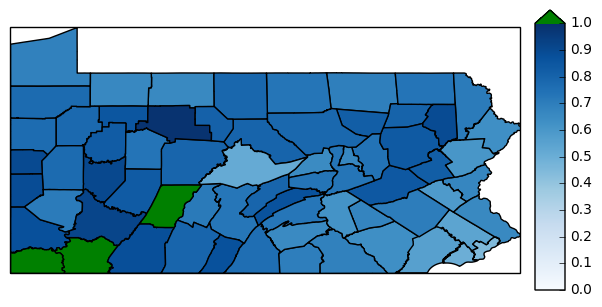

In [43]:
# Examine how votes correspond to total registered voters for particular parties, by county

colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

values = {}
for k,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[k]
    total = sum(meta.values())
    clinton = meta[DC]
    trump = meta[RC]
    vap = VOTERS[k]["ALL"]
#     color = total/vap
#     value = int(meta["CLINTON, HILLARY"])/int(VOTERS[k]["DEM"])
#     value = int(meta["TRUMP, DONALD J"])/int(VOTERS[k]["REP"])
#     value = int(meta["TRUMP, DONALD J"])/sum([int(VOTERS[k]["REP"]), int(VOTERS[k]["OTH"]), int(VOTERS[k]["NOF"])])
    value = trump/((vap-VOTERS[k][DEM])-(total-trump-clinton))
#     value = clinton/((vap-VOTERS[k]["REP"])-(total-trump-clinton))
    color = colormap(value)
    values[k] = color
    if value > 1:
        print(k, value)

plot_pa_data(values, cmap=colormap)

0.781357745809 0.611632768174
['Adams: 0.7119042978997706', 'Allegheny: 0.6956432861439822', 'Armstrong: 0.7430438052265463', 'Beaver: 0.6959293469168523', 'Bedford: 0.6859257109692397', 'Berks: 0.6772109995688859', 'Blair: 0.6684868497128393', 'Bradford: 0.6827972696608324', 'Bucks: 0.7476509484153266', 'Butler: 0.7480169283781596', 'Cambria: 0.726719668164535', 'Cameron: 0.6761521806371791', 'Carbon: 0.6802539020866394', 'Centre: 0.6173778386748932', 'Chester: 0.7525804621546329', 'Clarion: 0.7275631716526285', 'Clearfield: 0.6438770525682936', 'Clinton: 0.6903139013452915', 'Columbia: 0.6643401170621801', 'Crawford: 0.7023735926113266', 'Cumberland: 0.7282019040776001', 'Dauphin: 0.6876888396117852', 'Delaware: 0.6909087826299688', 'Elk: 0.712641406906091', 'Erie: 0.6502781370600544', 'Fayette: 0.6411977961695328', 'Forest: 0.7199039327529271', 'Franklin: 0.7495700219288817', 'Fulton: 0.7339719168390116', 'Greene: 0.6620185922974767', 'Huntingdon: 0.6616970551694034', 'Indiana: 0.72

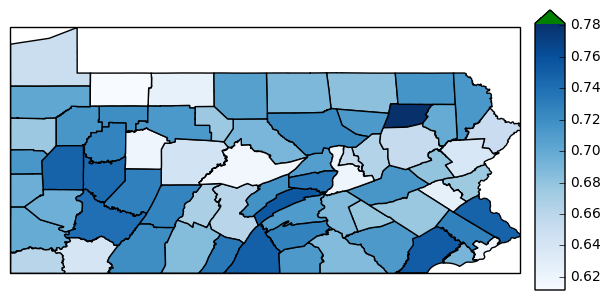

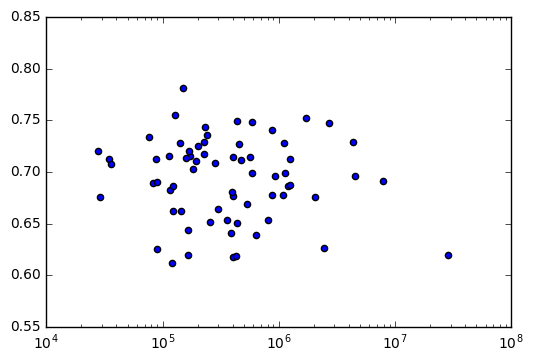

In [44]:
# colormap = cm.get_cmap("bwr_r")
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

norm = colors.Normalize()

to_plot = []
for county,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[county]
    total = sum(meta.values())
    clinton = meta[DC]
    trump = meta[RC]
    vap = VOTERS[county]["ALL"]
    
    republicans = VOTERS[county]["REP"]/vap*100
    democrats = VOTERS[county]["DEM"]/vap*100
    value = ((clinton-trump)/total*100)-(democrats-republicans)
    value =total/vap
    d = vap/v.area
    to_plot.append((county, v, value, d))

norm.autoscale_None([k[2] for k in to_plot])
print(norm.vmax, norm.vmin)
m = max(abs(norm.vmax), abs(norm.vmin))
# norm = colors.Normalize(vmin=-m, vmax=m)

sm = cm.ScalarMappable(norm=norm, cmap=colormap)

values = {}
for (county, shape, value, g) in to_plot:
    color = sm.to_rgba(value)
    values[county] = color
#     print("sm:", county, value, color)

print([x[0] + ": " + str(x[2]) for x in sorted(to_plot, key=lambda x: x[0])])
    
plot_pa_data(values, cmap=colormap, norm=norm)

plt.figure()
plt.scatter([x[3] for x in to_plot], [x[2] for x in to_plot])
ax = plt.gca()
ax.set_xscale('log')
plt.show()

-0.814283567434


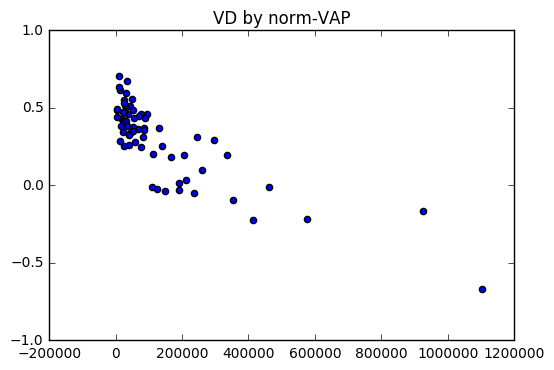

In [127]:
from scipy import stats

results = get_year_results(2016)
counties = sorted(results.keys())
vap = [results[c]['vap'] for c in counties]
# vap = [i/max(vap) for i in vap]

x = [results[c]['value'][0] for c in counties]
fig = plt.figure()
ax = fig.gca()
ax.scatter(vap, x)
# ax.set_xscale('log')
# ax.plot([0,1],[1,-1], 'k--')
# ax.plot([0,1],[0,0], 'k--')
# ax.set_xlim([0,1])
ax.set_ylim([-1,1])
ax.set_title("VD by norm-VAP")

print(stats.pearsonr(vap, x)[0])



[-38.34465780930415, 11.623915697094676, -34.4458130945675, -15.928849899950748, -0.45707988527535726, -16.503523713288835, -29.386523739017612, -36.16644336895717, -14.119031035119361, 0.9356092683468944, -14.198407022655978, -55.616510549202616, -20.23859938797255, -20.328587201796054, -29.653798492336715, -28.41800085729795, -19.600853404989355, -3.947183982604585, -28.793889831136823, -13.913787700581715, 17.728621176865914, -25.821993200306, -12.498192988996458, -21.8906931838133, -16.556037697906625, 0.041017506783038726, -15.859449866688422, -14.595523691939029, 14.461174468789737, -31.760982395881598, -36.29158399966531, -36.286241897730044, -17.407216559992822, -36.058065337058466, -14.772136673844969, -24.232672519846517, -51.582096881624196, -1.2345200700326968, -13.0328907316615, -14.792319867917158, -24.45862613707406, -31.702141681479475, -0.3311431392942339, -22.74822568633429, -27.28960402086992, -61.244734646613594, -21.979040723239798, -9.985612893895485, -35.77597748

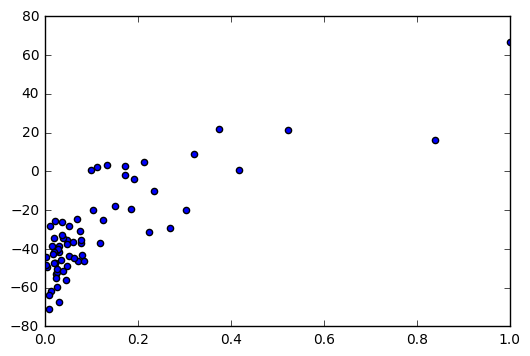

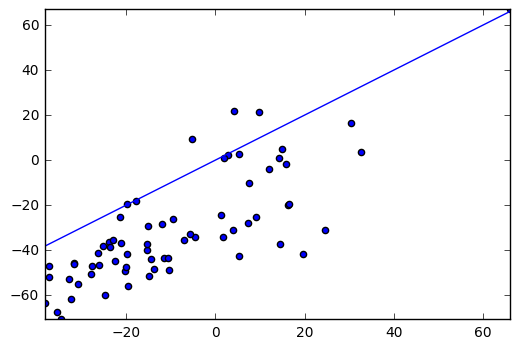

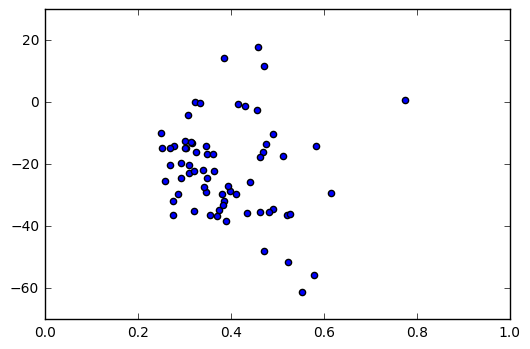

In [45]:
x=[]
clintons = []
trumps=[]
counties = COUNTY_RESULTS.keys()
vap=[int(dict(VOTERS[c])["ALL"]) for c in counties]
vap = [i/max(vap) for i in vap]

for county in COUNTY_RESULTS.keys():
    meta = COUNTY_RESULTS[county]
    total = sum(meta.values())
    clinton = meta[DC]
    trump = meta[RC]
    x.append((clinton-trump)/total*100)
    trumps.append(trump/total*100)
    clintons.append(clinton/total*100)
#     x.append((total-clinton-trump)/total*100)
plt.figure()
plt.scatter(vap,x)
plt.xlim([0,1])

republicans = [int(dict(VOTERS[c])["REP"])/int(dict(VOTERS[c])["ALL"]) for c in counties]
democrats = [int(dict(VOTERS[c])["DEM"])/int(dict(VOTERS[c])["ALL"]) for c in counties]
x_v = [(i-j)*100 for i,j in zip(democrats,republicans)]
plt.figure()
plt.scatter(x_v, x)
print([i-j for i,j in zip(x, x_v)])
plt.plot([-100,100],[-100,100])
plt.xlim([min(x_v),max(x_v)])
plt.ylim([min(x),max(x)])
# plt.xlim([0,1])
plt.figure()
plt.scatter(democrats,[i-j for i,j in zip(x,x_v)])
plt.xlim([0,1])
# plt.figure()
# plt.scatter(vap,democrats)
# plt.xlim([0,1])
plt.show()


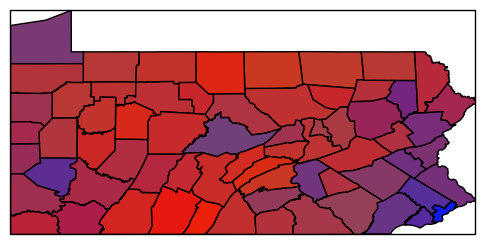

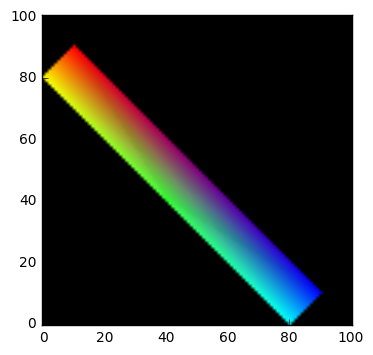

In [18]:
ax = plt.axes(projection=ccrs.PlateCarree())


# fig = plt.figure()#figsize=(8, 3))
# ax = fig.add_axes([0.05, 0.05, 0.85, 0.9], projection=ccrs.PlateCarree())
# ax2 = fig.add_axes([0.925, 0.15, 0.05, 0.7])

# ax = plt.axes(projection=ccrs.PlateCarree())
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

# cmap = gen_cmap([[0,0], [100,0], [0,100]], [(0.5,0,0.5), (0,0,1), (1,0,0)])
# cmap = gen_cmap([[0,0], [100,0], [0,100]], [(0.5,0,0.5), (0,0,1), (1,0,0)])
cmap = cmap2d.ColorMapCrude([[80,0], [90,10], [10,90], [0,80], [40,40]], 
                            [(0,1,1), (0,0,1), (1,0,0), (1,1,0), (0,1,0)])

# values = []
# for county,v in COUNTY_RESULTS.items():
#     meta = dict(COUNTY_RESULTS[k])
#     del meta["County"]
#     total = sum([int(f) for f in meta.values()])
#     vap = int(dict(VOTERS[k])["ALL"])
#     value = int(meta["TRUMP, DONALD J"])/sum([int(VOTERS[k]["REP"]), int(VOTERS[k]["OTH"]), int(VOTERS[k]["NOF"])])

for k,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[k]
    total = sum(meta.values())
    clinton = meta[DC]
    trump = meta[RC]
    point = [clinton/total*100, trump/total*100]
    (x,y) = point
    if 95>x+y:
        print (k, int(x+y))
    color = cmap(point)
    cf = cfeature.ShapelyFeature([v], ccrs.PlateCarree())
    ax.add_feature(cf, facecolor=color)

ax.set_extent([-80.5198510000000027,-74.7215190000000007,39.7211469999999949,42.5160720000000012])
ax.set_aspect(1)

# cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=colormap, norm=colors.Normalize(vmin=0, vmax=1), extend='max')

plt.show()

cmap2d.plot_cmap(cmap, scale=1, bounds=cmap._coords, constrain=True)

plotting SimplexColorMap shape 0
plotting TernaryColorMap shape 0
plotting ProjectionColorMap shape 0
plotting AvgColorMap shape 0


/home/ocderby/Documents/code/elections_2016/src/cmap2d/cmap2d/cmap2d.py:90: RuntimeWarning: divide by zero encountered in true_divide
  distances = self._max_dist/distances


plotting ColorMapCrude shape 0
plotting ColorMap shape 0
plotting ColorMap2 shape 0


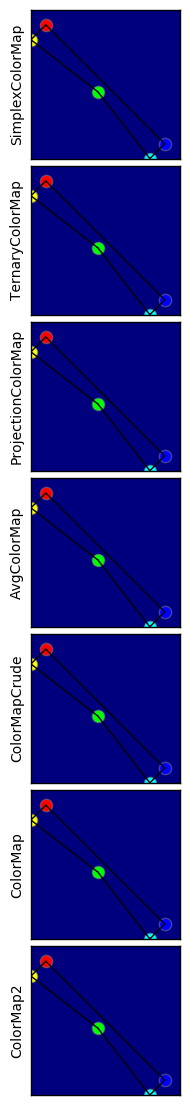

In [16]:
case = [[cmap._coords, cmap._colors]]
classes = [cmap2d.SimplexColorMap, cmap2d.TernaryColorMap, cmap2d.ProjectionColorMap, cmap2d.AvgColorMap,
           cmap2d.ColorMapCrude, cmap2d.ColorMap, cmap2d.ColorMap2]
cmap2d.run_tests(classes,case, scale=1, constrain=False)

In [57]:
PAPER = 0
MIXED = 1
DRE = 2

VOTE_METHOD = {
"Adams": PAPER,
"Allegheny": DRE,
"Armstrong": DRE,
"Beaver": DRE,
"Bedford": MIXED,
"Berks": DRE,
"Blair": DRE,
"Bradford": DRE,
"Bucks": DRE,
"Butler": DRE,
"Cambria": DRE,
"Cameron": DRE,
"Carbon": DRE,
"Centre": PAPER,
"Chester": MIXED,
"Clarion": DRE,
"Clearfield": DRE,
"Clinton": DRE,
"Columbia": MIXED,
"Crawford": DRE,
"Cumberland": MIXED,
"Dauphin": DRE,
"Delaware": DRE,
"Elk": DRE,
"Erie": DRE,
"Fayette": MIXED,
"Forest": DRE,
"Franklin": PAPER,
"Fulton": PAPER,
"Greene": DRE,
"Huntingdon": PAPER,
"Indiana": PAPER,
"Jefferson": DRE,
"Juniata": PAPER,
"Lackawanna": PAPER,
"Lancaster": MIXED,
"Lawrence": DRE,
"Lebanon": DRE,
"Lehigh": DRE,
"Luzerne": MIXED,
"Lycoming": DRE,
"Mckean": DRE,
"Mercer": DRE,
"Mifflin": PAPER,
"Monroe": DRE,
"Montgomery": DRE,
"Montour": PAPER,
"Northampton": DRE,
"Northumberland": DRE,
"Perry": DRE,
"Philadelphia": DRE,
"Pike": DRE,
"Potter": DRE,
"Schuylkill": DRE,
"Snyder": PAPER,
"Somerset": DRE,
"Sullivan": DRE,
"Susquehanna": PAPER,
"Tioga": DRE,
"Union": DRE,
"Venango": DRE,
"Warren": DRE,
"Washington": DRE,
"Wayne": PAPER,
"Westmoreland": MIXED,
"Wyoming": DRE,
"York": DRE
}

In [58]:
counties = VOTE_METHOD.keys()
x = [VOTE_METHOD[c] for c in counties]
totals = []
clinton = []
trump = []
delta = []
for c in counties:
    meta = dict(COUNTY_RESULTS[c])
    del meta["County"]
    total = sum([int(f) for f in meta.values()])
    totals.append(total)
    clinton.append(int(meta[DC])/total)
    trump.append(int(meta[RC])/total)
    delta.append((clinton[-1]-trump[-1])*100)
plt.figure()
plt.scatter(x,y)
plt.figure()
plt.scatter(x,clinton, color='blue')
plt.scatter(x,trump, color='red', marker='x')
plt.figure()
plt.scatter(x,delta)
d = np.array(delta)
k = np.array(x)

means_x = list(set(x))
means = [stat.mean(d[k==i]) for i in means_x]
medians = [stat.median(d[k==i]) for i in means_x]
plt.scatter(means_x, means, marker='+', color='red')
plt.scatter(means_x, medians, marker='x', color='green')
print(means[2]-means[1])
plt.show()

KeyError: 'County'

In [ ]:
scale=100

data = dict()
for (i, j, k) in simplex_iterator(scale):
    data[(i, j, k)] = cmap((i,j))

figure, tax = ternary.figure(scale=scale)
tax.heatmap(data, style="triangular", colormap=False) # Allow colors as rgba tuples
tax.boundary()

tax.ticks(axis='lbr', multiple=10, linewidth=1)
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()

plt.show()